In [1]:
import pandas as pd
df = pd.read_parquet("../data/processed/so_clean.parquet")
print(df.shape)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/so_clean.parquet'

In [2]:
import pathlib as pl, os
print("Notebook is running in:", pl.Path.cwd())


Notebook is running in: C:\Users\CMLUser5\Desktop\burnout-ai-study


In [3]:
import pathlib as pl
print(list(pl.Path("data/processed").glob("*.parquet")))


[WindowsPath('data/processed/so_clean.parquet')]


In [4]:
import pandas as pd
df = pd.read_parquet("data/processed/so_clean.parquet")
print(df.shape)


(39041, 119)


ai_freq
0    9.325482
1    8.176101
Name: burnout, dtype: float64


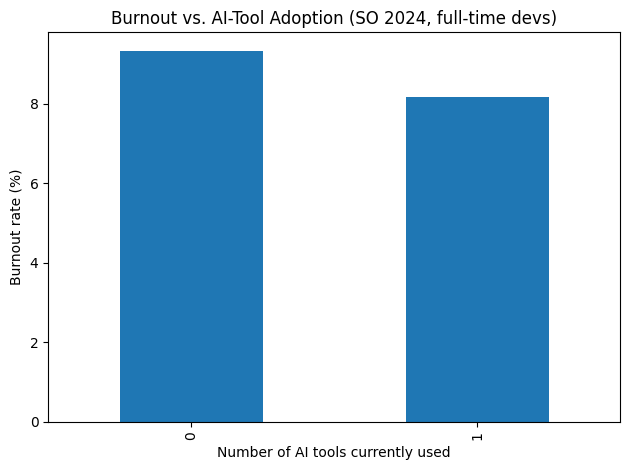

In [5]:
import matplotlib.pyplot as plt

# 1.  calculate burnout percentage for each ai_freq
burnout_rates = (
    df.groupby('ai_freq')['burnout']
      .mean()                # mean of 0/1 == % burned out
      .mul(100)              # convert to percent
      .sort_index()
)

print(burnout_rates)         # see the numbers

# 2.  bar chart
burnout_rates.plot(kind='bar')
plt.ylabel('Burnout rate (%)')
plt.xlabel('Number of AI tools currently used')
plt.title('Burnout vs. AI-Tool Adoption (SO 2024, full-time devs)')
plt.tight_layout()
plt.show()


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# ❶ map the integer codes to readable labels
remote_labels = {0: "Hybrid", 1: "In-person", 2: "Remote", -1: "Missing"}
df['remote_label'] = df['remote_code'].map(remote_labels)

# ❷ print a quick table of burnout rates (%)
pivot = (
    df[df['remote_code'] != -1]                # skip the 15 missing
      .groupby(['remote_label', 'ai_freq'])['burnout']
      .mean()
      .mul(100)
      .round(1)
      .unstack()                               # columns = ai_freq
)
print("Burnout % by remote mode and AI-tool count:\n")
print(pivot, "\n")                             # <- paste this table back to me

# ❸ grouped bar chart
sns.barplot(
    data=df[df['remote_code'] != -1],          # skip missing label
    x='ai_freq', y='burnout', hue='remote_label',
    estimator=lambda x: 100 * x.mean()
)
plt.ylabel('Burnout rate (%)')
plt.xlabel('Number of AI tools currently used')
plt.title('Burnout vs AI-Tool Adoption by Work Arrangement')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

Burnout % by remote mode and AI-tool count:

ai_freq               0          1
remote_label                      
Hybrid         8.823529   7.323319
In-person     10.578426  11.240762
Remote         9.232651   7.572897 



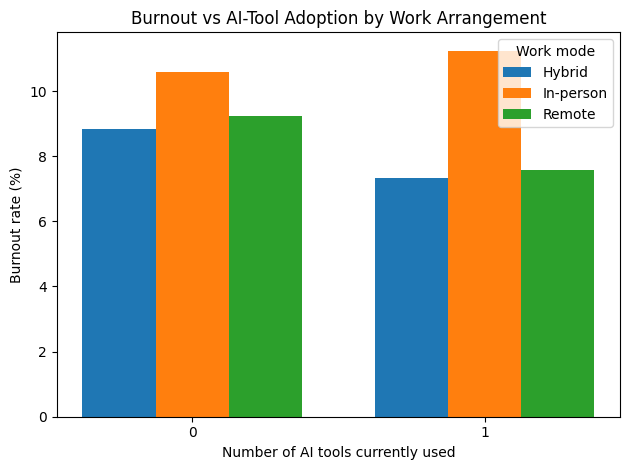

In [7]:
import matplotlib.pyplot as plt

remote_labels = {0: "Hybrid", 1: "In-person", 2: "Remote", -1: "Missing"}
df['remote_label'] = df['remote_code'].map(remote_labels)

pivot = (
    df[df['remote_code'] != -1]
      .groupby(['remote_label', 'ai_freq'])['burnout']
      .mean()
      .mul(100)
      .unstack()
)

print("Burnout % by remote mode and AI-tool count:\n")
print(pivot, "\n")

# simple grouped bars with matplotlib
fig, ax = plt.subplots()
width = 0.25
x = pivot.columns  # ai_freq values (0,1)

for i, label in enumerate(pivot.index):
    ax.bar(x + i*width, pivot.loc[label], width, label=label)

ax.set_ylabel('Burnout rate (%)')
ax.set_xlabel('Number of AI tools currently used')
ax.set_title('Burnout vs AI-Tool Adoption by Work Arrangement')
ax.set_xticks(x + width)
ax.set_xticklabels(x)
ax.legend(title='Work mode')
plt.tight_layout()
plt.show()


Burnout % for in-person devs, by age bucket and AI-tool count:

ai_freq        0     1
age_bucket            
18–24       16.5  14.6
25–34       10.1  10.9
35–44        8.1   8.3
45–54        9.5   7.0
55+          8.5   8.3 



C:\Users\CMLUser5\AppData\Local\Temp\ipykernel_9700\658421960.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  in_person.groupby(['age_bucket', 'ai_freq'])['burnout']


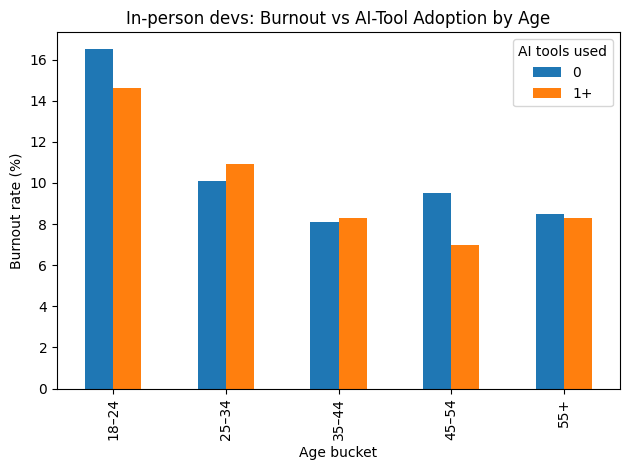

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) keep only in-person rows
in_person = df[df['remote_label'] == 'In-person'].copy()

# 2) create age buckets
age_bins  = [0, 24, 34, 44, 54, 120]
age_labels = ['18–24', '25–34', '35–44', '45–54', '55+']
in_person['age_bucket'] = pd.cut(in_person['age'], bins=age_bins, labels=age_labels, right=True)

# 3) burnout % table
pivot_age = (
    in_person.groupby(['age_bucket', 'ai_freq'])['burnout']
             .mean()
             .mul(100)
             .round(1)
             .unstack()
)
print("Burnout % for in-person devs, by age bucket and AI-tool count:\n")
print(pivot_age, "\n")           # ← please copy this table back to me

# 4) bar chart
pivot_age.plot(kind='bar')
plt.ylabel('Burnout rate (%)')
plt.xlabel('Age bucket')
plt.title('In-person devs: Burnout vs AI-Tool Adoption by Age')
plt.legend(title='AI tools used', labels=['0', '1+'])
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import statsmodels.formula.api as smf

# keep only rows with no missing predictors
cols = ['burnout', 'ai_freq', 'age', 'years_code', 'remote_code']
data = df[cols].dropna().copy()

# treat remote_code as categorical
data['remote_code'] = data['remote_code'].astype(int).astype("category")

# fit logistic regression
model = smf.logit('burnout ~ ai_freq + age + years_code + C(remote_code)', data=data).fit()

print(model.summary())              # full stats table
print("\nOdds ratios:\n", np.exp(model.params).round(3))


NameError: name 'df' is not defined

In [2]:
import pandas as pd, numpy as np
import statsmodels.formula.api as smf

# 1) reload the cleaned dataset
df = pd.read_parquet("data/processed/so_clean.parquet")

# 2) keep only rows with all predictors present
cols = ['burnout', 'ai_freq', 'age', 'years_code', 'remote_code']
data = df[cols].dropna().copy()

# 3) treat work-mode as categorical
data['remote_code'] = data['remote_code'].astype(int).astype("category")

# 4) fit logistic regression
model = smf.logit('burnout ~ ai_freq + age + years_code + C(remote_code)', data=data).fit()

# 5) show odds ratios
print("\n---  Odds ratios  ---")
print(np.exp(model.params).round(3))


         Current function value: 0.289155
         Iterations: 35

---  Odds ratios  ---
Intercept              0.000000e+00
C(remote_code)[T.0]    7.994826e+07
C(remote_code)[T.1]    1.015893e+08
C(remote_code)[T.2]    8.449047e+07
ai_freq                8.320000e-01
age                    1.006000e+00
years_code             9.790000e-01
dtype: float64


C:\Users\CMLUser5\Desktop\burnout-ai-study\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [3]:
data['remote_bin'] = (df['remote_code'] == 2).astype(int)  # 1 = fully remote; 0 = everything else


In [4]:
model2 = smf.logit('burnout ~ ai_freq + age + years_code + remote_bin', data=data).fit()
print(np.exp(model2.params).round(3))


Optimization terminated successfully.
         Current function value: 0.289481
         Iterations 6
Intercept     0.108
ai_freq       0.829
age           1.005
years_code    0.979
remote_bin    0.980
dtype: float64


In [5]:
plt.savefig("overall_burnout_vs_ai.png", dpi=150, bbox_inches="tight")
print("✅  Image saved")


NameError: name 'plt' is not defined

In [6]:
import matplotlib.pyplot as plt
plt.savefig("overall_burnout_vs_ai.png", dpi=150, bbox_inches="tight")
print("✅  Image saved")


✅  Image saved


<Figure size 640x480 with 0 Axes>

✅  Chart re-saved to overall_burnout_vs_ai.png


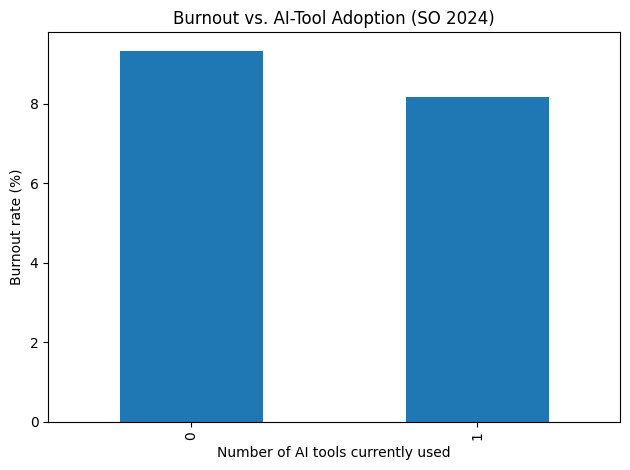

In [7]:
import matplotlib.pyplot as plt

# Re-calculate burnout % for each ai_freq value
burnout_rates = (
    df.groupby('ai_freq')['burnout']
      .mean()
      .mul(100)
)

# Draw the bar chart
burnout_rates.plot(kind='bar')
plt.ylabel('Burnout rate (%)')
plt.xlabel('Number of AI tools currently used')
plt.title('Burnout vs. AI-Tool Adoption (SO 2024)')
plt.tight_layout()

# Save right after drawing
plt.savefig("overall_burnout_vs_ai.png", dpi=150, bbox_inches="tight")
print("✅  Chart re-saved to overall_burnout_vs_ai.png")


✅  Saved to burnout_by_workmode.png


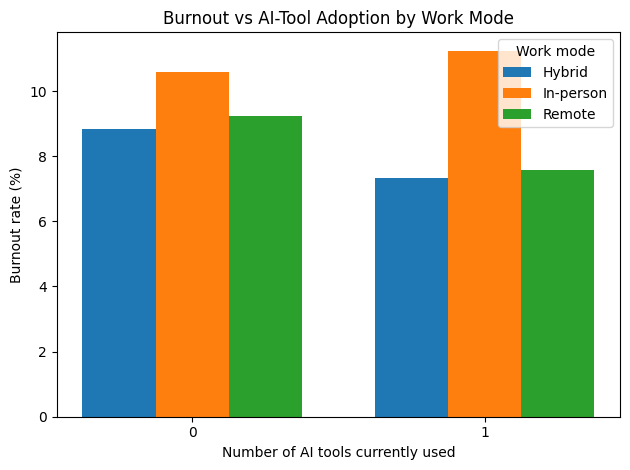

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) prepare the data (skip the 15 missing work-mode rows)
remote_labels = {0: "Hybrid", 1: "In-person", 2: "Remote"}
work_df = df[df['remote_code'] != -1].copy()
work_df['remote_label'] = work_df['remote_code'].map(remote_labels)

# 2) compute burnout % for each (work mode × ai_freq)
pivot = (
    work_df.groupby(['remote_label', 'ai_freq'])['burnout']
           .mean()
           .mul(100)
           .unstack()
)

# 3) plot grouped bars with matplotlib
fig, ax = plt.subplots()
width = 0.25
x = pivot.columns               # ai_freq values 0,1
for i, label in enumerate(pivot.index):
    ax.bar(x + i*width, pivot.loc[label], width, label=label)

ax.set_ylabel('Burnout rate (%)')
ax.set_xlabel('Number of AI tools currently used')
ax.set_title('Burnout vs AI-Tool Adoption by Work Mode')
ax.set_xticks(x + width)
ax.set_xticklabels(x)
ax.legend(title='Work mode')
plt.tight_layout()

# 4) save the figure
plt.savefig("burnout_by_workmode.png", dpi=150, bbox_inches="tight")
print("✅  Saved to burnout_by_workmode.png")
